In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order

from statsmodels.iolib.summary2 import summary_col

In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

# load data

In [6]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)

topics_raw = topics[[i for i in topics.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)
topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()
topics = pd_join_freq(topics, 
             pd.DataFrame(pd_groupby(topics, ['T_sum'], 'M', 'last',).diff().iloc[:,0].rename('T_sum_diff_lag_M'),),
             'M')

hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [7]:
# shift pi
pi_shift = pi[~pi.index.duplicated()][['pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']].copy().dropna()
_ = pi_shift.shift(1).add_suffix("_SM").copy()
pi_shift = pi_shift[['pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']].asfreq('D').shift(18).add_suffix('_S').join(_).ffill().dropna()

## macro analysis

In [8]:
# join hhp data at recorded date
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'delta_pe_MY', 'pi_perc_MY', 
        'pi_perc_WY', 'percprob_war', 'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
        'pi_perc95_MY', 'pi_perc05_MY', 'pi_perc05_WY', 'pi_perc95_WY', 'pi_exp', 'eduwork_txt', 'pi_exp_MY', 'i_exp_MY',
        'pi_exp_WY', 'riskaversion', 'eduwork', 'savings_planned',
    ]
].drop_duplicates().copy()

# join hhp data at forecast date
# df = pd_join_dfs(
#     [
#         df,
#         hhp.set_index('date_forecast')[
#             ['pi_exp_MY', 'i_exp_MY', 'pi_exp975_MY', 'pi_exp975_WY', 'pi_exp025_MY', 'pi_exp025_WY', 'pi_exp_WY']
#         ].drop_duplicates().add_suffix("_F"),
#     ],
#     index_name='date_recorded'
# )

In [9]:
df = pd_join_freq(
    df,
    hhp.set_index('date_forecast')[
        ['pi_exp_MY', 'i_exp_MY', 'pi_exp975_MY', 'pi_exp975_WY', 'pi_exp025_MY', 'pi_exp025_WY', 'pi_exp_WY']
    ].drop_duplicates().add_suffix("_F"),
    'W',
)

In [10]:
# get uncertainty 
df['pi_exp_uncertainty_WY_F'] = df['pi_exp975_WY_F'] - df['pi_exp025_WY_F']
df['pi_perc_uncertainty_WY'] = df['pi_perc95_WY'] - df['pi_perc05_WY']

df['pi_exp_uncertainty_MY_F'] = df['pi_exp975_MY_F'] - df['pi_exp025_MY_F']
df['pi_perc_uncertainty_MY'] = df['pi_perc95_MY'] - df['pi_perc05_MY']

In [11]:
df = df.join(pi_shift, how='left')
df.index.name = 'date_recorded'

In [12]:
# join other dfs
df = pd_join_freq(df, topics, "W", True)
df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_de_Y_diff']], 'M', True)
# df = pd_join_freq(df, pi_shift, 'D', True)
df = df.join(bei.bei)

In [13]:
# set index and time frequncies
df['week_recorded'] = df.index.to_period('W').to_timestamp()
df['week_forecast'] = df.date_forecast.dt.to_period('W').dt.to_timestamp()
df['month_recorded'] = df.date_recorded.dt.to_period('M').dt.to_timestamp()

df = df.reset_index(drop=True)

In [14]:
# get residuals
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], agg_col_suffix='all', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], count_thresh=6)

df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_S']], agg_col_suffix='all_S', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_S']], agg_col_suffix="S", count_thresh=6)

df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_SM']], agg_col_suffix='all_SM', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_SM']], agg_col_suffix="SM", count_thresh=6)

df = get_individual_perc_error(df, 'delta_pe_MY', pi[['pi_de_Y_diff']], ind_cols=['date_forecast', 'id'], count_thresh=5)
df = get_individual_perc_error(df, 'pi_exp_MY', pi[['pi_de_Y']], ind_cols=['date_forecast', 'id'], count_thresh=5)

In [15]:
# get residuals monthly
for col in [
    ('recorded', 'delta_pe_MY_error_act'), ('recorded', 'pi_perc_MY_all_error_act'),
    ('recorded', 'pi_perc_MY_all_S_error_act'), ('recorded', 'pi_perc_MY_all_SM_error_act')
]:

    sub = df[[f'date_{col[0]}', f'week_{col[0]}', 'id', col[1]]].drop_duplicates().dropna().groupby(f'week_{col[0]}')[col[1]].median().copy()
    sub /= 100
    df = pd_join_freq(df.set_index('date_recorded'), pd.DataFrame(sub.rename(f'{col[1]}_WY')), 'W', keep_left_index=True).copy()
    df = pd_join_freq(df, 
                     pd_groupby(pd.DataFrame(sub.rename(f'{col[1]}_MY')), [f'{col[1]}_MY'], 'M', 'last'),
                     'M', keep_left_index=True)
df = df.reset_index(drop=True)

In [16]:
# check

In [17]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    33440.000000
mean         1.987440
std          1.525668
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max          9.000000
dtype: float64

In [30]:
save_pd_df(df, "df_analysis.feather")

## micro analysis

In [84]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y',  'pi_de_surprise_Y', 'pi_de_estimate_Y',]],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(
    df_micro, 
    topics[['T_sum', 'T_sum_diff_lag']].drop_duplicates(), 
    "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

df_micro['pi_perc_error'] = df_micro['pi_perc'] - df_micro.pi_de_Y
df_micro['delta_pe_error'] = df_micro['delta_pe'] - df_micro.pi_de_Y

_ = df[['pi_de_Y', 'pi_perc_WY']].apply(lambda x: x.iloc[1] - x.iloc[0], axis=1).copy().rename('pi_perc_error')
df['pi_perc_error'] = _

In [85]:
save_pd_df(df_micro, 'df_analysis_micro.feather')

# desrcb stats

In [77]:
sub = df.set_index(['id', 'week_recorded'])[
    ['pi_perc', 'delta_pe', 'pi_exp', 'hhinc_midpoint', 'riskaversion', 'pi_perc_MY_error_act', 'delta_pe_MY_error_act',]
].drop_duplicates().sort_index().astype(float).describe().copy()

sub.loc['N individuals'] = np.zeros(sub.shape[1])
sub.loc['N weeks'] = np.zeros(sub.shape[1])
sub.loc['dtype'] = np.zeros(sub.shape[1]).astype(str)

sub = sub.rename(index={'count': 'N'})

for col in sub:
    _ = df[['id', 'week_recorded'] + [col]].drop_duplicates().dropna().copy()
    sub.loc['N weeks', col] = len(_.week_recorded.unique())
    sub.loc['N individuals', col] = len(_.id.unique())
        
sub = sub.astype(float).round(2)
sub = sub.join(
    df[
        ['week_recorded', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'T_sum_diff_lag']
    ].drop_duplicates().iloc[:,1:].describe().rename(index={'count': 'N month'}).round(2), 
    how='outer', ) #sort=True)

sub = sub.rename(index={'25%': 'Q1', "75%": "Q2"}).drop("50%")
for col in sub:
    sub.loc['dtype', col] = str(DICT_PARSE_COLS[col])

sub = sub.fillna("").sort_index(ascending=True).loc[
    ['mean', 'std', 'min', 'max', 'Q1', 'Q2', 'N', 'N individuals', 'N weeks', 'N month', 'dtype']
]
save_pd_df(sub, "data_describtives.csv", GRAPHS_DIR)

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_4128\4205599440.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<class 'float'>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sub.loc['dtype', col] = str(DICT_PARSE_COLS[col])
C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_4128\4205599440.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'categoryO' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sub.loc['dtype', col] = str(DICT_PARSE_COLS[col])


In [78]:
sub = df[
    ['month_recorded', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'delta_pe_MY', 'pi_perc_MY', 'T_sum_diff_lag_M', 
     'pi_perc_MY_error_act', 'delta_pe_MY_error_act']
].drop_duplicates().dropna().iloc[:,1:].corr().round(3).copy()
save_pd_df(sub, "data_corr_matrix.csv", GRAPHS_DIR)

## plot time series inflation

In [ ]:
df.pi_perc_MY__S_error_act

In [80]:
sub = pd_groupby(df.set_index('date_recorded'),
           ['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY', 'pi_exp_MY', 
            'pi_perc95_MY', 'pi_perc05_MY'],
           "M", 'last').dropna()
sub = pd_join_freq(sub,
                   pd_groupby(df.set_index('date_recorded'),
                              ['pi_perc_MY_error_act', 'pi_perc_MY__S_error_act', 'delta_pe_MY_error_act'], 'M', 'mean'),
                   'M')
sub2 = pd_groupby(df.set_index('date_forecast'), 
                  ['pi_de_Y', 'pi_exp975_MY_F', 'pi_exp025_MY_F', 'pi_de_estimate_Y', 'pi_exp_MY_F', 'delta_pe_MY_error_act'], 
                  'M', 'last').dropna()

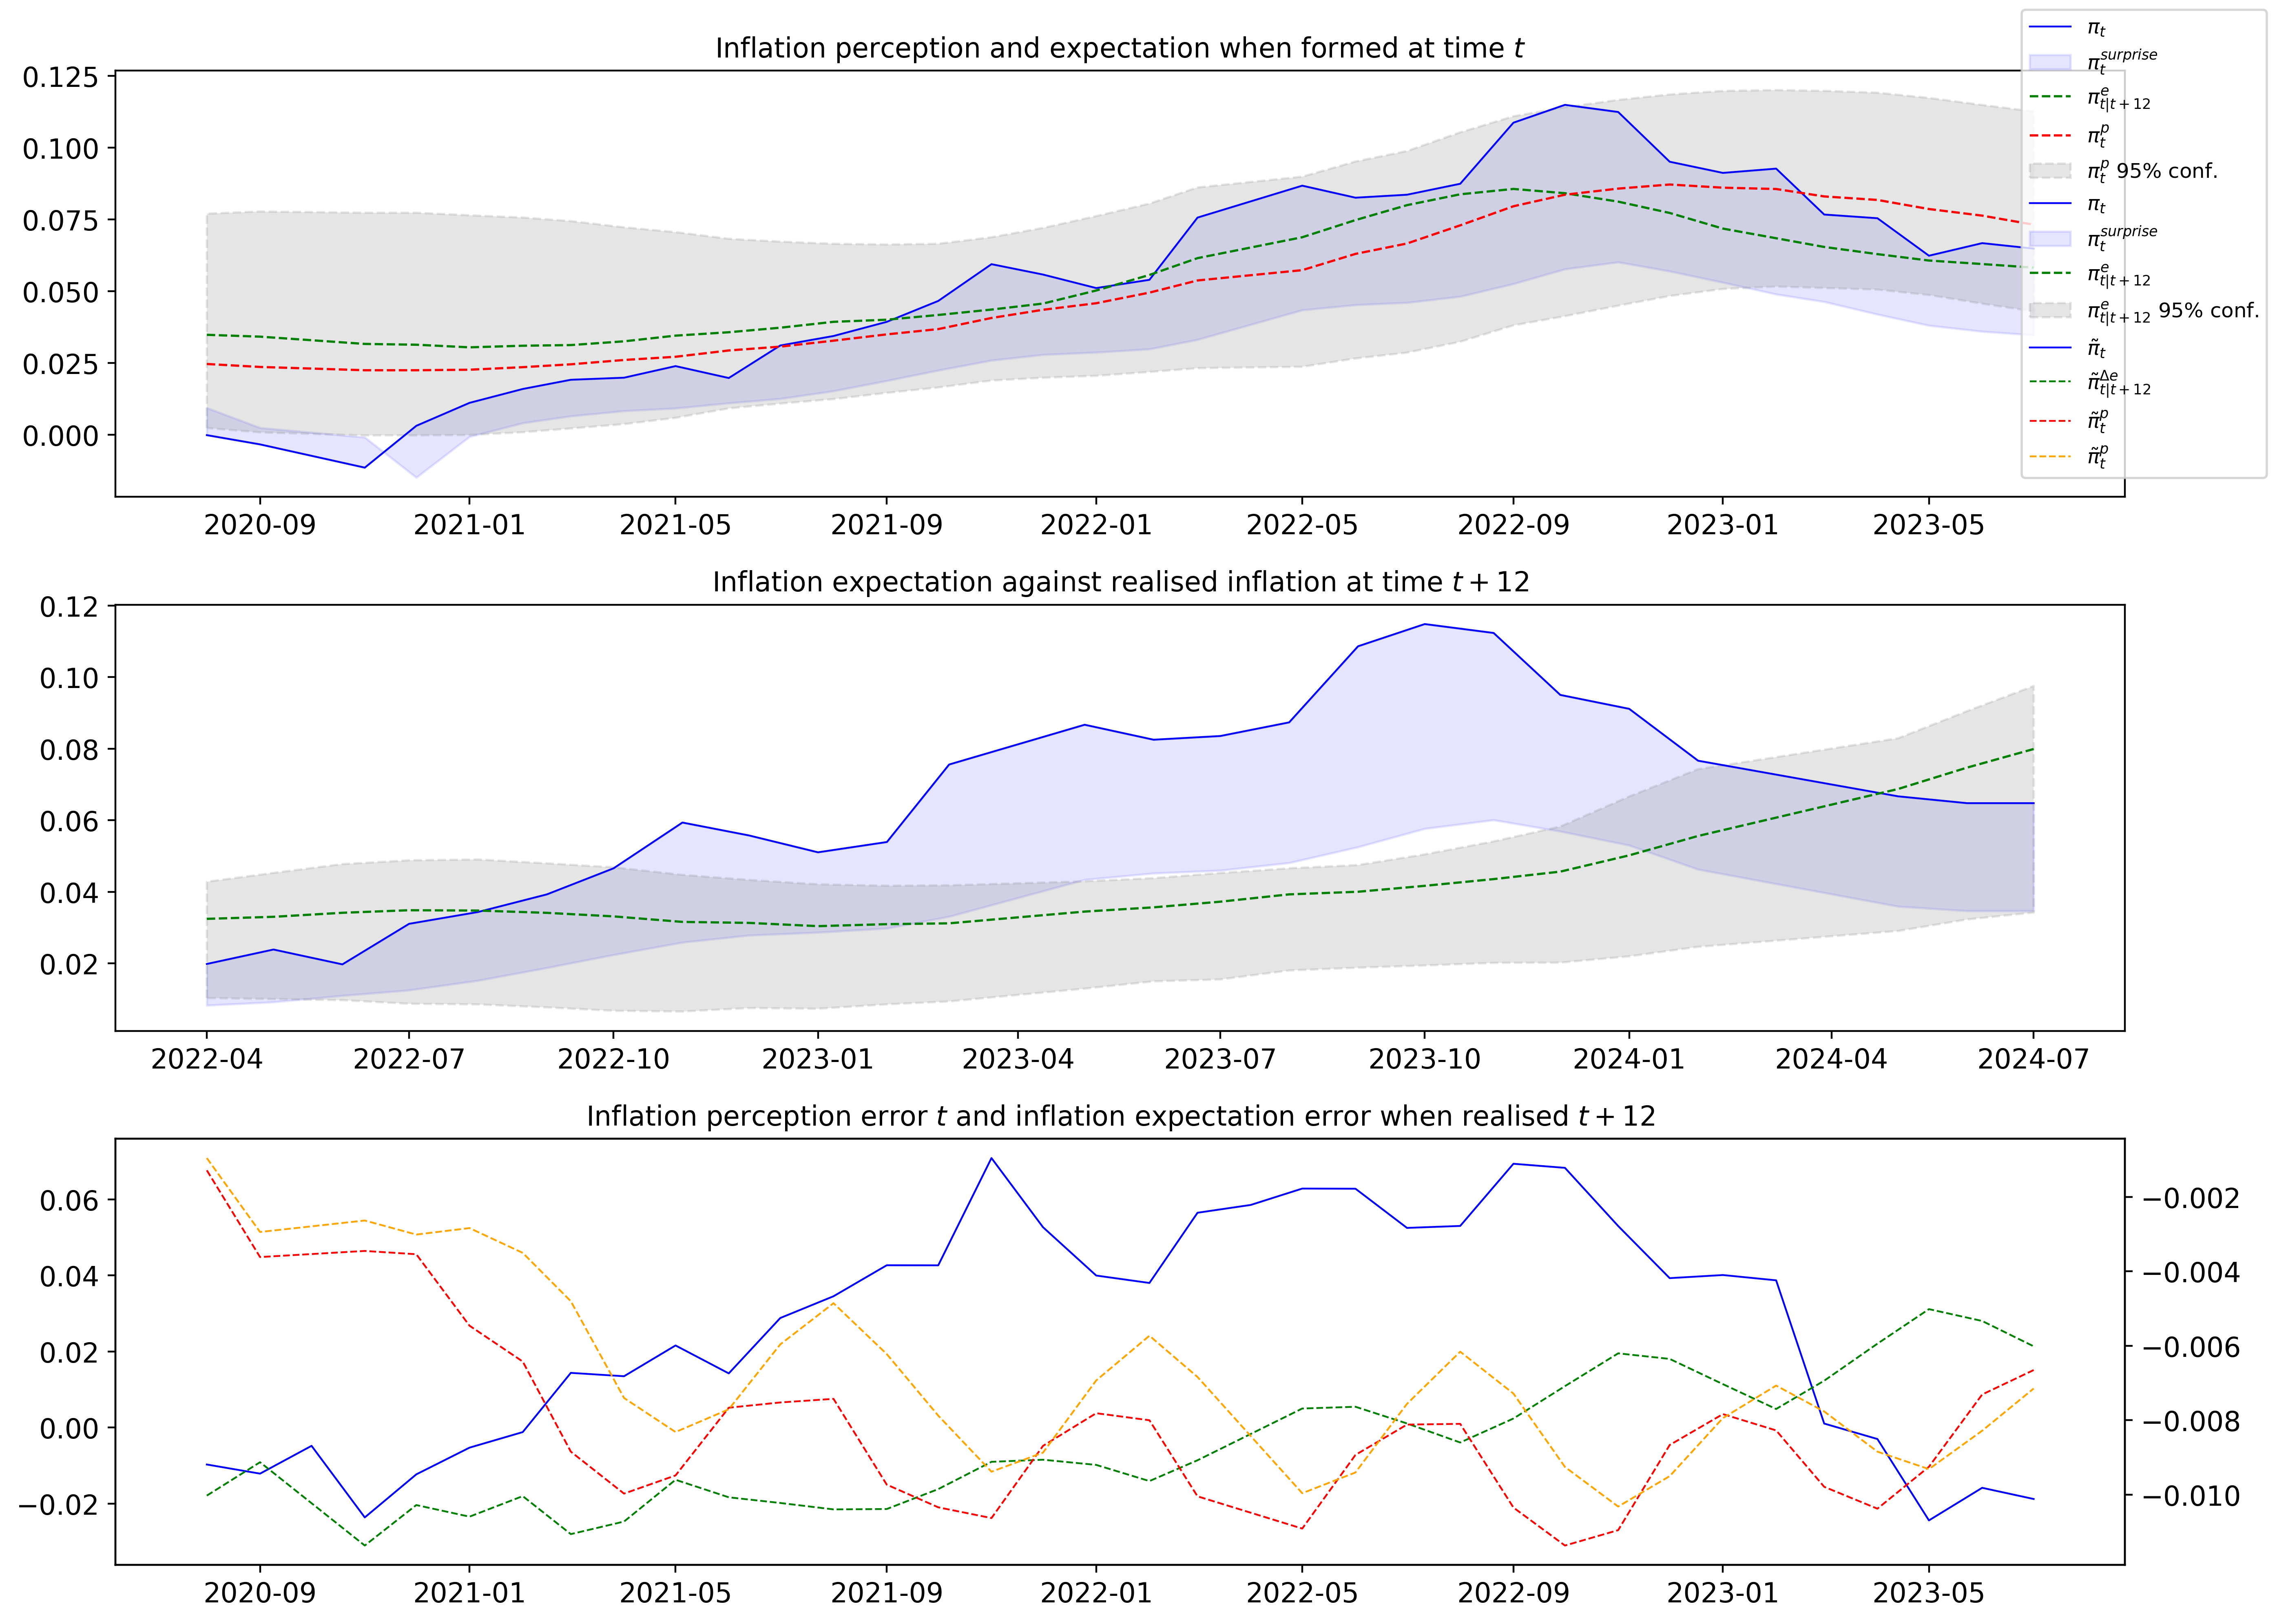

In [83]:
fig, ax = plt.subplots(3,1, figsize=(14,10), dpi=400)

ax[0].plot(sub['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[0].fill_between(sub.index, sub['pi_de_estimate_Y'], sub['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)

ax[0].plot(sub['pi_exp_MY'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[0].plot(sub['pi_perc_MY'], linestyle='dashed', color='red', lw=1, label=r'$\pi^p_{t}$')
ax[0].fill_between(sub.index, sub['pi_perc95_MY'], sub['pi_perc05_MY'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^p_{t}$ 95% conf.')

ax[0].set_title('Inflation perception and expectation when formed at time $t$', size=12)

ax[1].plot(sub2['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[1].fill_between(sub2.index, sub2['pi_de_estimate_Y'], sub2['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)
ax[1].plot(sub2['pi_exp_MY_F'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[1].fill_between(sub2.index, sub2['pi_exp975_MY_F'], sub2['pi_exp025_MY_F'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^e_{t|t+12}$ 95% conf.')
ax[1].set_title("Inflation expectation against realised inflation at time $t+12$", size=12)

_pi = pi.loc[sub.index.min(): sub.index.max()].copy()
ax[2].plot(_pi['pi_de_Y_diff'], color='blue', lw=.8, label='$\~{\pi}_t$')
ax[2].plot(sub['delta_pe_MY_error_act']/100, lw=.8, color='green', linestyle='dashed', label='$\~{\pi}^{\Delta e}_{t|t+12}$')
ax[2].set_title("Inflation perception error $t$ and inflation expectation error when realised $t+12$", size=12)

ax22 = ax[2].twinx()
ax22.plot(sub['pi_perc_MY_error_act']/100, lw=.8, color='red', linestyle='dashed', label='$\~{\pi}^{p}_t$')
ax22.plot(sub['pi_perc_MY__S_error_act']/100, lw=.8, color='orange', linestyle='dashed', label='$\~{\pi}^{p}_t$')

fig.legend(prop={'size': 9})
fig.tight_layout()

save_fig(fig, 'plot_inflation.png')

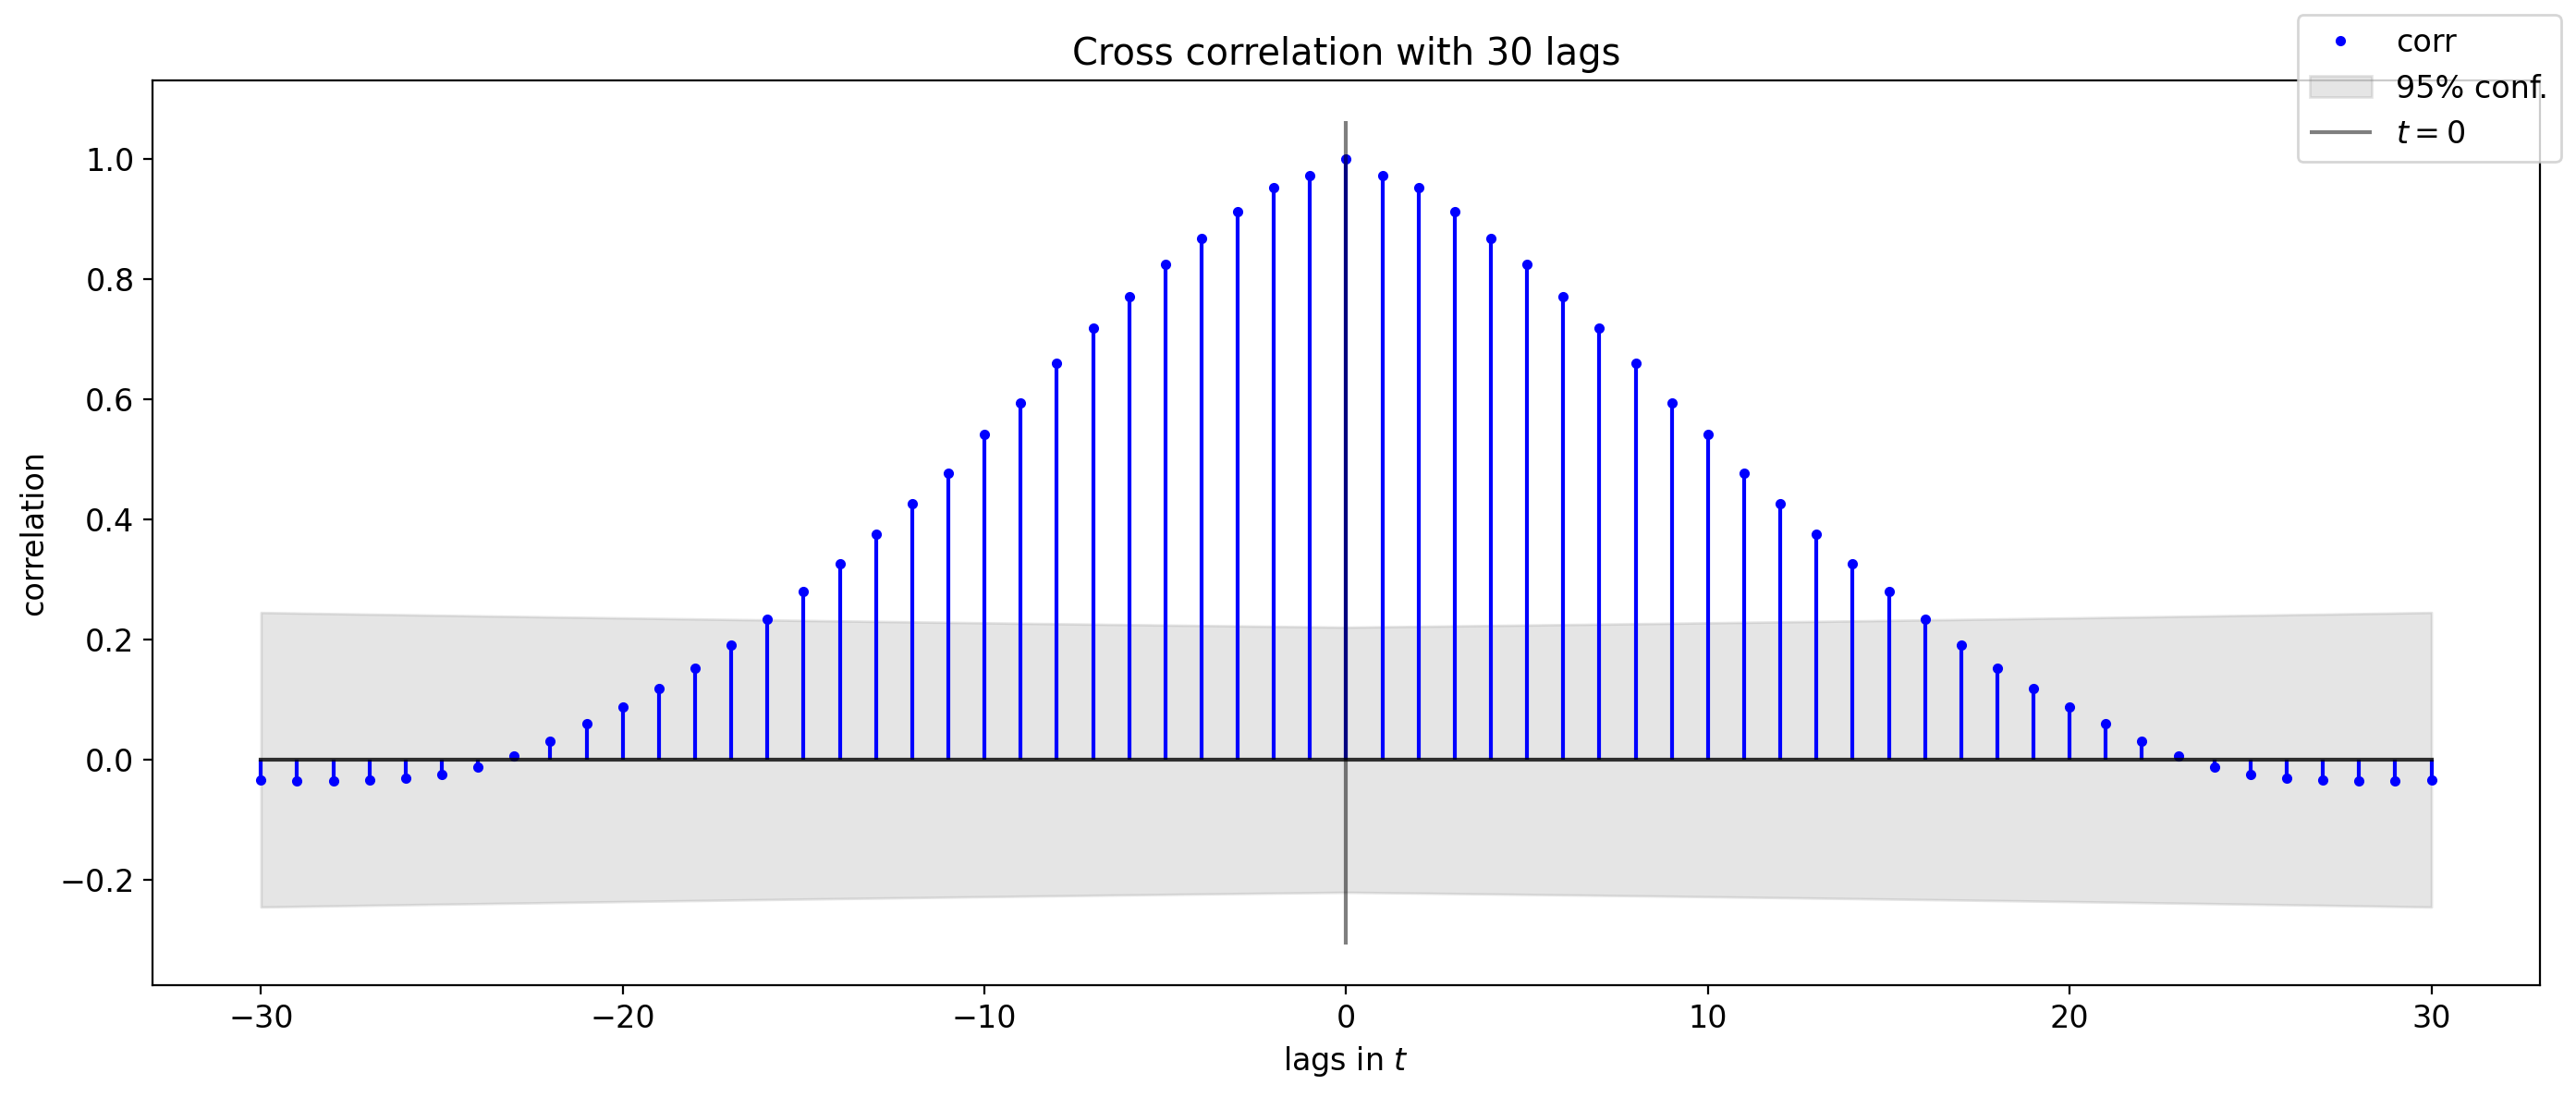

In [18]:
xcorr(pi.pi_de_estimate_Y.dropna(), n_lags=30);

## overview on news and narratives

In [19]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy().drop('date', axis=1) #.iloc[:300]

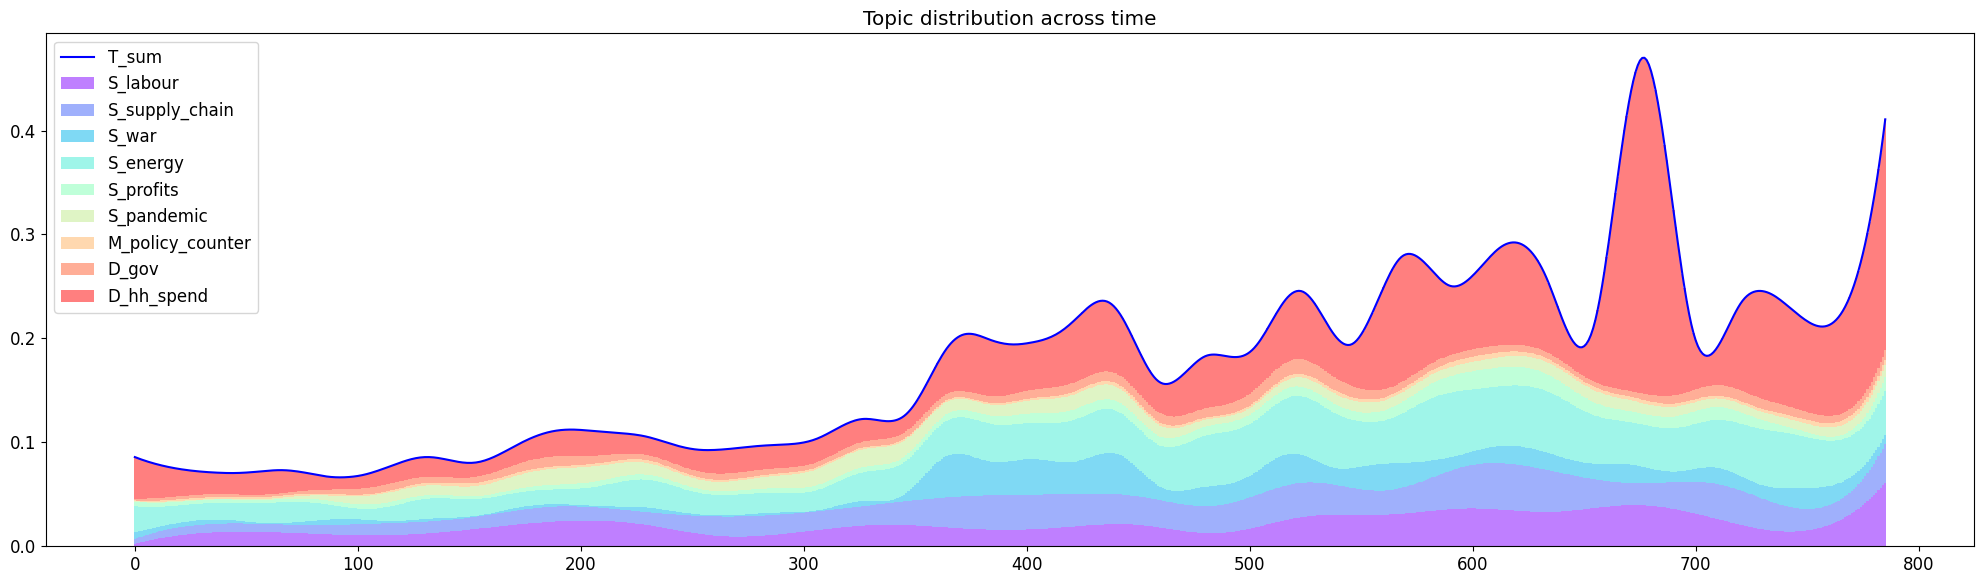

In [20]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag', 'T_sum_diff_lag_M'], axis=1), )

ax.plot(sub.T_sum.values, color='blue', label='T_sum')
ax.set_title("Topic distribution across time")
ax.legend(loc="upper left")
fig.tight_layout()
save_fig(fig, "topics_time.png")

### media and BEI

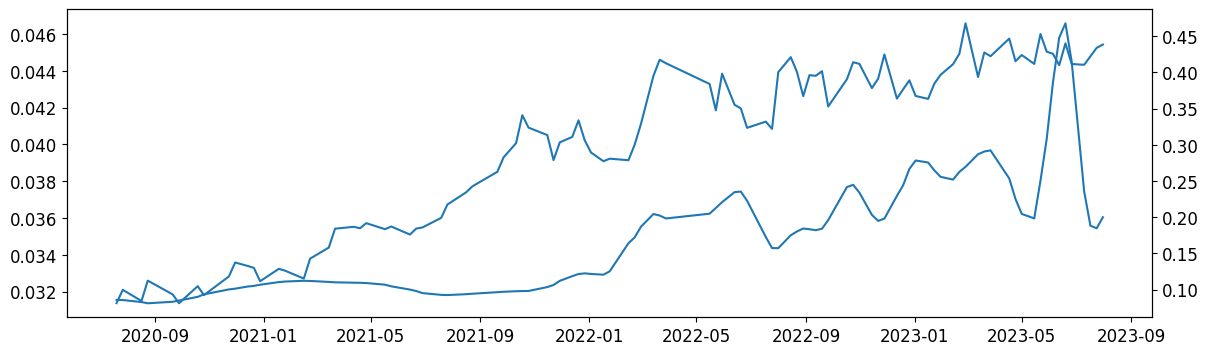

In [21]:
sub = df[['week_recorded', 'bei', 'T_sum']].groupby('week_recorded').last().dropna().copy()
fig, ax = get_fig_subplots()
ax.plot(sub.bei)
ax.twinx().plot(sub.T_sum)

### war and inflation as given by hh concern

In [22]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

cols_endog, cols_exog = ['S_war'], ['percprob_war']
_dict = {'percprob_war': 'War perceived', 'percprob_covid': 'Covid-19 perceived', 'S_war': 'War report', 'S_pandemic': 'Covid-19 report'}

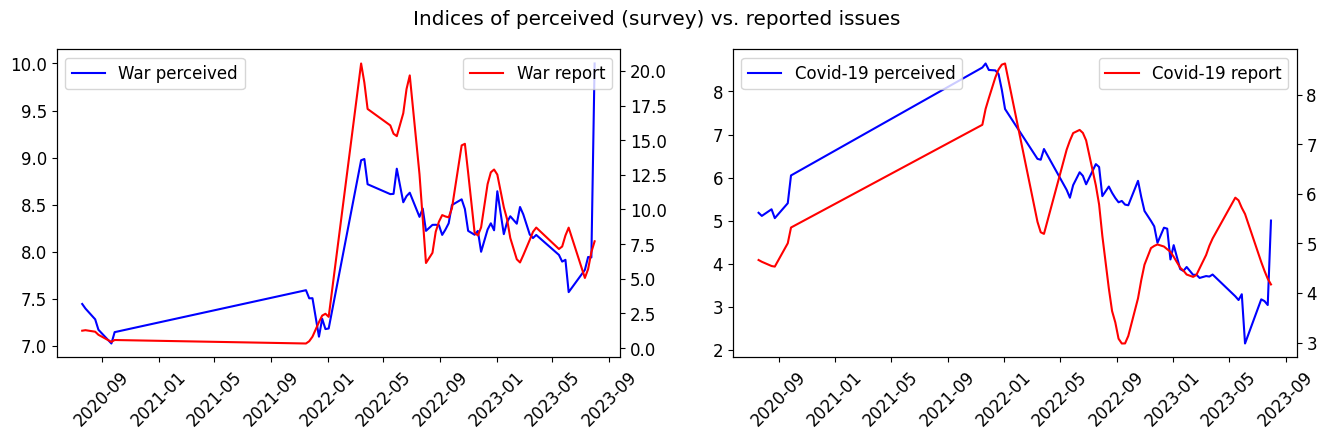

In [23]:
fig, axes = get_fig_subplots(2,2, figsize=(16,2))
lst_cols = [('percprob_war', 'S_war'), ('percprob_covid', 'S_pandemic')]
for idx, ax in enumerate(axes):
    ax.plot(sub[lst_cols[idx][0]], label=_dict[lst_cols[idx][0]], color='blue')
    ax2 = ax.twinx()
    ax2.plot(sub[lst_cols[idx][1]], label=_dict[lst_cols[idx][1]], color='red')
    ax2.legend(loc='upper right')
    ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=45)
# axes[0].legend([
fig.suptitle("Indices of perceived (survey) vs. reported issues")
save_fig(fig, "topics_percprob.png")

In [24]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'pi_perc_MY_error_act', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum']
                 , 'M', 'last').dropna()
sub = pd_join_freq(sub,
             pd_groupby(df.set_index('date_recorded'), ['delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',], 'M', 'mean'),
             'M',
            )
sub['pi_perc_MY_error_act'] /= 100
sub['delta_pe_MY_error_act_MY'] /= 10

## plot errors

In [ ]:
fig, axes = get_fig_subplots(3, 3, figsize=(14,1.5))
for i, ax in enumerate(axes):
    ax.set_title(lst_error_cols[i], size=10)
    ax.hist(df[['id', lst_error_cols[i]]].drop_duplicates().drop('id', axis=1).dropna(), color='blue', alpha=.8, density=True)
    ax.set_title(dict_cols_pretty_names[lst_error_cols[i]])
    
fig.suptitle("Expectation and Perception Residuals")
fig.tight_layout();
save_fig(fig, 'emp_error_hist.png')